In [1]:
import glob, os, time
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import splev, splrep
import myconstants as const

#import lalsimulation
#from pycbc import waveform
import matplotlib.pyplot as plt
plt.style.use('classic') 

def save_obj(path, obj, name ):
    with open(path + name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(path, name ):
    with open(path + name + '.pkl', 'rb') as f:
        return pickle.load(f)
    
def symm_tidal_params(lambda1,lambda2,q):
    """
    Calculate best tidal parameters [Eqs. (5) and (6) in Wade et al. PRD 89, 103012 (2014)]
    Requires q <= 1
    """
    lambdap = lambda1 + lambda2
    lambdam = lambda1 - lambda2
    # Check that q <= 1, as expected
    if np.any(q > 1):
        raise ValueError("q > 1, while this function requires q <= 1.")
    dmbym = (1. - q)/(1. + q) # Equivalent to sqrt(1 - 4*eta) for q <= 1
    eta = q2eta(q)
    lam_tilde = (8./13.)*((1.+7.*eta-31.*eta*eta)*lambdap + dmbym*(1.+9.*eta-11.*eta*eta)*lambdam)
    dlam_tilde = (1./2.)*(dmbym*(1.-13272.*eta/1319.+8944.*eta*eta/1319.)*lambdap + (1.-15910.*eta/1319.+32850.*eta*eta/1319.+3380.*eta*eta*eta/1319.)*lambdam)
    return lam_tilde, dlam_tilde



################################ Ejecta Mass fits from Numerical Simulations ##################################################################
def Compactness_MBaryon(mass_input,eoskey):  #,pathEoS):

    #"""    
    mass_radius_file_loc='./m_mB_rad_data/'
    massradius_file=mass_radius_file_loc+eoskey+'.npy'
    mass_radius_rhoc_mbaryon=np.load(massradius_file)
    mass=np.array(mass_radius_rhoc_mbaryon[0])   #0:mass(msun), 1:radius(km), 2:rhoc(cgs), 3:lambda (in cgs)
    #if(mass_input>max(mass)): ##code it up as Assertion error
    #    raise ValueError('The input mass is greater than the maximum supported by the EOS:%s'%eoskey)
        
    Radius=np.array(mass_radius_rhoc_mbaryon[1])
    massBaryon=mass_radius_rhoc_mbaryon[3]
    lambda_dimensional = mass_radius_rhoc_mbaryon[4]

    sort_ind=mass.argsort()                 # sorting mass and other array; necessary for interpolation routine
    mass=mass[sort_ind[::1]]
    Radius=Radius[sort_ind[::1]]
    massBaryon=massBaryon[sort_ind[::1]]
    lambda_dimensional=lambda_dimensional[sort_ind[::1]]

    ## To check interpolation error
    #mass=mass[0::2]
    #Radius=Radius[0::2]
    #lambda_dimensional=lambda_dimensional[0::2]
    #massBaryon=massBaryon[0::2]
    
    radius_out=splev(mass_input,splrep(mass,Radius,k=3,s=0)) 
    mbaryon_out=splev(mass_input,splrep(mass,massBaryon,k=3,s=0))
    lambda_out=splev(mass_input,splrep(mass,lambda_dimensional,k=3,s=0))
    lambda_dimensionless = (lambda_out*const.CGS_G)*((const.CGS_C**2)/(const.CGS_G*mass_input*const.CGS_MSUN))**5

    return (const.CGS_G*mass_input*const.CGS_MSUN)/(radius_out*1.e5*const.CGS_C**2), lambda_dimensionless, radius_out   #from tov solver
    #return (const.CGS_G*mass_input*const.CGS_MSUN)/(radius_out*1.e5*const.CGS_C**2), mass_input+(13./200.)*mass_input**2  #from approx fit for baryon mass  #Give reference here
    

In [2]:
def eos_from_pres(pres_in,eos_file='./eos_tables/ALF2_data.out'):
    
    fm=1.e-13 #1femotometer in cm
    dens_conversion=const.CGS_AMU/(fm**3)
    edens_conversion=const.CGS_C**2
    
    ds=np.loadtxt(eos_file,comments='#')
    rho, edens, pres = (ds[:,1],ds[:,2],ds[:,3])
    
    #dp_dedens_arr=diff(pres)/diff(edens)/edens_conversion
    #dp_dedens_arr = np.insert(dp_dedens_arr, 0, dp_dedens_arr[0], axis=0)

    dp_dedens_arr=np.gradient(pres,edens)/edens_conversion #https://numpy.org/doc/stable/reference/generated/numpy.gradient.html
    gamma_arr=((edens*edens_conversion+pres)/pres) * dp_dedens_arr 
    
    rho_out=splev(pres_in,splrep(pres,rho,k=3,s=0)) 
    edens_out=splev(pres_in,splrep(pres,edens,k=3,s=0)) 
    gamma_out=splev(pres_in,splrep(pres,gamma_arr,k=3,s=0))
    dp_dedens_out=splev(pres_in,splrep(pres,dp_dedens_arr,k=3,s=0))
    #gamma_out=5./3.
    
    return rho_out*dens_conversion, edens_out*edens_conversion, gamma_out

def eos_from_dens(rho_in,eos_file='./eos_tables/ALF2_data.out'):
    
    fm=1.e-13 #1femotometer in cm
    dens_conversion=const.CGS_AMU/(fm**3)
    edens_conversion=const.CGS_C**2
    
    ds=np.loadtxt(eos_file,comments='#')
    rho, edens, pres = (ds[:,1],ds[:,2],ds[:,3])
    
    pres_out=splev(rho_in,splrep(rho,pres,k=3,s=0)) 
    edens_out=splev(rho_in,splrep(rho,edens,k=3,s=0)) 
    
    return pres_out, edens_out*edens_conversion

1.660538921e-24
time taken is 8.8291 seconds
time taken is 0.0169 seconds


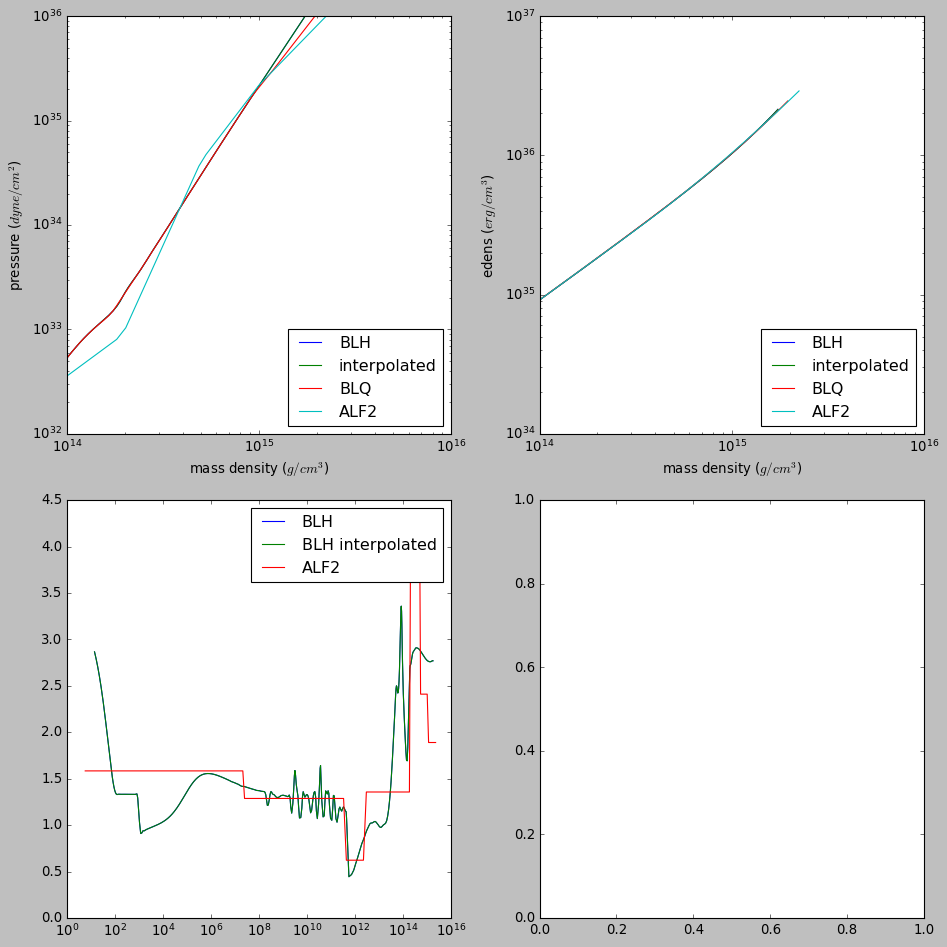

In [121]:
#blh=np.loadtxt('./eos_tables/sfho+BL_01-Apr-2019.lorene',comments='#')
blh=np.loadtxt('./eos_tables/BLH_new_14-Apr-2020.lorene',comments='#')
blq=np.loadtxt('./eos_tables/BLQ_gibbs_180_10-Mar-2020.lorene',comments='#',skiprows=8)
alf2=np.loadtxt('./eos_tables/ALF2_data.out',comments='#')

#print(ds[:,1])
rho, edens, p = (blh[:,1],blh[:,2],blh[:,3])
print(const.CGS_AMU)
fm=1.e-13 #1femotometer in cm
dens_conversion=const.CGS_AMU/(fm**3)
edens_conversion=const.CGS_C**2

p_new=np.logspace(14,36,500)


tic = time.perf_counter()


for p in p_new:
    rho_new,edens_new,gamma_new=eos_from_pres(p_new,'./eos_tables/BLQ_gibbs_180_10-Mar-2020.lorene')

toc = time.perf_counter() 

print(f"time taken is {toc - tic:0.4f} seconds")

tic = time.perf_counter()

rho_new,edens_new,gamma_new=eos_from_pres(p_new,'./eos_tables/BLQ_gibbs_180_10-Mar-2020.lorene')
toc = time.perf_counter() 

print(f"time taken is {toc - tic:0.4f} seconds")



key='BLQ'
rho_new,edens_new,gamma_new=eos_from_pres(p_new,'./eos_tables/BLQ_gibbs_180_10-Mar-2020.lorene') #returns in cgs
index=np.array([int(i) for i in range(len(p_new))])
np.savetxt(f'./eos_tables/{key}_data.out',np.c_[index, rho_new/dens_conversion, edens_new/edens_conversion, p_new, gamma_new],header='\n#i rho edens pres gamma',comments=f'#density, pressure and energy density in cgs units for eos={key}.\n')

key='BLH'
rho_new,edens_new,gamma_new=eos_from_pres(p_new,'./eos_tables/BLH_new_14-Apr-2020.lorene') #returns in cgs
index=np.array([int(i) for i in range(len(p_new))])
np.savetxt(f'./eos_tables/{key}_data.out',np.c_[index, rho_new/dens_conversion, edens_new/edens_conversion, p_new, gamma_new],header='\n#i rho edens pres gamma',comments=f'#density, pressure and energy density in cgs units for eos={key}.\n')




blh=np.loadtxt('./eos_tables/BLH_data.out',comments='#')
blq=np.loadtxt('./eos_tables/BLQ_data.out',comments='#')
               
fig,((ax1,ax2),(ax3,ax4))=plt.subplots(nrows=2,ncols=2,figsize=(12,12))
ax1.plot(blh[:,1]*dens_conversion,blh[:,3],label='BLH')
ax1.plot(rho_new,p_new,label='interpolated')
ax1.plot(blq[:,1]*dens_conversion,blq[:,3],label='BLQ')
ax1.plot(alf2[:,1]*dens_conversion,alf2[:,3],label='ALF2')
ax1.set_xlim([1.e14,1.e16])
ax1.set_ylim([1.e32,1.e36])
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set(xlabel=r'mass density ($g/cm^{3}$)',ylabel=r'pressure ($dyne/cm^2$)')
ax1.legend(loc=4)

ax2.plot(blh[:,1]*dens_conversion,blh[:,2]*edens_conversion,label='BLH')
ax2.plot(rho_new,edens_new,label='interpolated')
ax2.plot(blq[:,1]*dens_conversion,blq[:,2]*edens_conversion,label='BLQ')
ax2.plot(alf2[:,1]*dens_conversion,alf2[:,2]*edens_conversion,label='ALF2')
ax2.set_xlim([1.e14,1.e16])
ax2.set_ylim([1.e34,1.e37])
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set(xlabel=r'mass density ($g/cm^{3}$)',ylabel=r'edens ($erg/cm^{3}$)')
ax2.legend(loc=4)

ax3.plot(rho_new,gamma_new,label='BLH')
ax3.plot(blh[:,1]*dens_conversion,blh[:,4],label='BLH interpolated')
ax3.plot(alf2[:,1]*dens_conversion,alf2[:,4],label='ALF2')
ax3.set_xscale('log')
ax3.legend()

plt.tight_layout()
#plt.savefig('eos_plots_phase.png',dpi=150)

plt.show()


[[2.00000000e+00 1.66353802e+00 1.42325529e+00 1.24751440e+00
  1.11053889e+00 9.98290986e-01 9.06967371e-01 8.31355758e-01
  7.67231265e-01 7.11907115e-01 6.64041986e-01 6.22401117e-01
  5.85874874e-01 5.53478744e-01 5.24353340e-01 4.97937132e-01
  4.74017834e-01 4.52317187e-01 4.32575284e-01 4.14551162e-01
  3.98022801e-01 3.82787125e-01 3.68659999e-01 3.55476235e-01
  3.43142473e-01 3.31622931e-01 3.20852287e-01 3.10768750e-01
  3.01314067e-01 2.92433522e-01 2.84075935e-01 2.76193663e-01
  2.68742602e-01 2.61682184e-01 2.54975379e-01 2.48588692e-01
  2.42498649e-01 2.36696504e-01 2.31164884e-01 2.25886867e-01
  2.20846400e-01 2.16028304e-01 2.11418271e-01 2.07002863e-01
  2.02769517e-01 1.98706537e-01 1.94803102e-01 1.91049261e-01
  1.87435935e-01 1.83954918e-01 1.80599083e-01 1.77362768e-01
  1.74240210e-01 1.71225834e-01 1.68314317e-01 1.65500582e-01
  1.62779800e-01 1.60147389e-01 1.57599018e-01 1.55130601e-01
  1.52738301e-01 1.50418530e-01 1.48167946e-01 1.45983455e-01
  1.4386

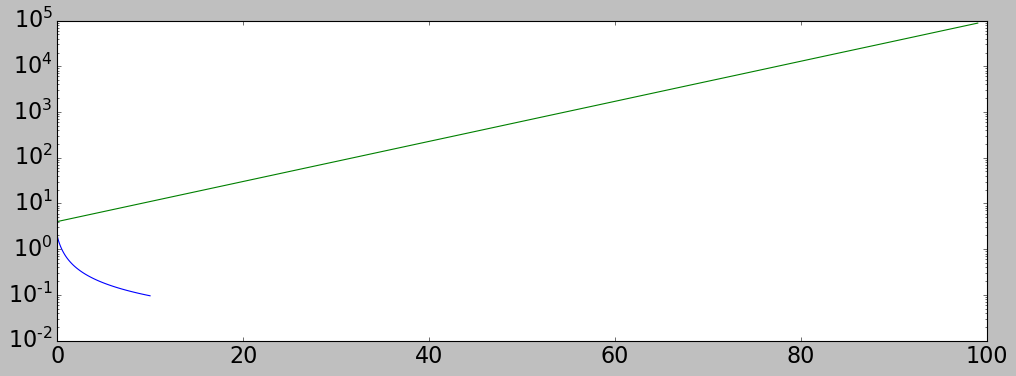

In [100]:
from scipy.integrate import solve_ivp
def exponential_decay(t, y): return -0.5 * y

def shm(t,y): 
    return [-y[0]**2,y[1]]

t_eval=np.linspace(0,10,100)
#sol = solve_ivp(exponential_decay, [0, 10], [2])
sol = solve_ivp(shm, [0, 10], [2,4],method='RK45',t_eval=t_eval)
#print(sol.t)


print(sol.y)

plt.plot(sol.t,sol.y[0],sol.y[1])
plt.yscale('log')
plt.show()

In [115]:
from scipy.integrate import odeint

import myconstants as const
from numpy import diff
import numpy as np

c=const.CGS_C
G=const.CGS_G
Msun=const.CGS_MSUN

fm=1.e-13 #1femotometer in cm
dens_conversion=const.CGS_AMU/(fm**3)
edens_conversion=const.CGS_C**2

#eos_file='./tov/m_mB_rad_data/ALF2_data.out'

#eos_file='../EOS_Data/BLQ_gibbs_180_10-Mar-2020.lorene'
#eos_file='../EOS_Data/BLQ_data.out'



#eos_files='../EOS_Data/sfho+BL_01-Apr-2019.lorene'
#eos_file = './eos_tables/BLH_data.out'
eos_file = './eos_tables/ALF2_data.out'

def calc_tidal_deformability(C, Y,m):
    """ Compute the dimensionless tidal deformability parameter Lambda from the compactness C and
    the Lindblom y-potential at the surface of a polytropic star"""
    # Eq.(C1,C2) of Lindblom & Indik 2014
    zeta = 4. * C**3 * (13. - 11.*Y + C*(3.*Y-2.) + 2.*(C**2)*(1.+Y)) + 3. * ((1.-2.*C)**2) * (2. - Y + 2.*C*(Y-1.)) *np.log(1.-2.*C) + 2. * C * (6. - 3.*Y + 3.*C*(5.*Y-8.))
    Lambda_dimensionless = (16./(15.*zeta)) * ((1.-2.*C)**2) * (2. + 2.*C*(Y-1.) - Y)  #dimensionless tidal deformability
    lambda_dimensional =   Lambda_dimensionless/G *(G*m*Msun/c**2)**5
    return lambda_dimensional

def tov(y, r):
    P, m, m_baryon, yp = y
    
    rho,eden,eos_gamma=eos_from_pres(P,eos_file)
    eden=eden/c**2.
    #eden = self.physical_eos.edens_inv( P )
    #rho = self.physical_eos.rho( P )
    #eos_gamma = self.physical_eos.gamma_inv(P)
    pi=np.pi
    dPdr = -G*(eden + P/c**2)*(m + 4.0*pi*r**3*P/c**2)
    dPdr = dPdr/(r*(r - 2.0*G*m/c**2))
    dmdr = 4.0*pi*r**2*eden
    dm_baryondr = 4.0*pi*r**2*rho*(1-2*G*m/(r*c**2))**(-0.5)
    #G=cgs.G; c=cgs.c

    # Eq.(C7) of Lindblom & Indik 2014
    rho=eden*c**2 #converting to cgs units
    dypdr= -yp**2/r -(r + (G/c**4)*4*np.pi*r**3*(P-rho)) * yp/(r*(r-2*G*m/c**2)) + (G**2/c**4)*(4*(m+4*np.pi*r**3*P/c**2)**2)/(r*(r-2*G*m/c**2)**2) + 6/(r-2*G*m/c**2) - 4*np.pi*(r**2)*(5*rho+9*P+(rho+P)**2/(P*eos_gamma))*G/(c**4 * (r-2*G*m/c**2))

    return [dPdr, dmdr, dm_baryondr,dypdr]

def tovsolve(rhoc):
    N = 500
    r = np.linspace(1e0, 38e5, N)
    #print(r)
    print(eos_file)
    P,dummy = eos_from_dens(rhoc/dens_conversion,eos_file)
    rho,eden,gamma = eos_from_pres(P,eos_file)
    #gamma=1.6
    eden=eden/c**2.
    #print(rho,eden,gamma)
    #P = self.physical_eos.pressure( rhoc )
    #eden = self.physical_eos.edens_inv( P )
    #rho = self.physical_eos.rho( P )
    pi=np.pi
    m = 4.0*pi*r[0]**3*eden
    m_baryon = 4.0*pi*r[0]**3*rho*(1-2*G*m/(r[0]*c**2))**(-0.5)
    yp=2.
    psol = odeint(tov, [P, m, m_baryon, yp], r, rtol=1.0e-4, atol=1.0e-4)
    #psol = solve_ivp(tov, )
    #print m, m_baryon, rhoc
    return r, psol[:,0], psol[:,1], psol[:,2], psol[:,3]

def mass_radius():
    N = 10
    mcurve = np.zeros(N)
    rcurve = np.zeros(N)
    mbcurve = np.zeros(N)
    ypcurve = np.zeros(N)
    rhocs = np.logspace(13.5, 15.5, N)
    print(rhocs)
    mass_max = 0.0
    j = 0
    for rhoc in rhocs:
        rad, press, mass, mass_baryon, yp_lambda = tovsolve(rhoc)
    
        rad  /= 1.0e5 #cm to km
        mass /= Msun
        mass_baryon /=Msun
        
        plt.semilogy(rad,press)
        plt.show()
        
        plt.plot(rad,mass)
        plt.show()
        #print(mass)
        
        #print self.peos
        #print rad
        #print "Central Density=%f, Gravitational Mass=%f, Baryonic Mass=%f, Radius=%f"%(rhoc,mass.max(),mass_baryon.max(),rad.max())

        mstar = mass[-1]
        rstar = rad[-1]
        ypstar = yp_lambda[-1]
        for i, p in enumerate(press):
            if p > 0.0:
                mstar = mass[i]
                rstar = rad[i]
                mbaryonStar = mass_baryon[i]
                ypstar = yp_lambda[i]
                
        mcurve[j] = mstar
        rcurve[j] = rstar
        mbcurve[j] = mbaryonStar

        C=(G/c**2)*(mstar*Msun)/(rstar*1.e5)
        ypcurve[j] = ypstar
        ypcurve[j] = calc_tidal_deformability(C,ypstar,mstar)



        j += 1
        print(j)
        """ if mass_max < mstar:
            mass_max = mstar
            print('break',mass_max,mstar)
        else:
            print('break',mass_max,mstar)
            break"""

    return mcurve[:j], rcurve[:j], rhocs[:j], mbcurve[:j], ypcurve[:j]

[3.16227766e+13 5.27499706e+13 8.79922544e+13 1.46779927e+14
 2.44843675e+14 4.08423865e+14 6.81292069e+14 1.13646367e+15
 1.89573565e+15 3.16227766e+15]
./eos_tables/ALF2_data.out


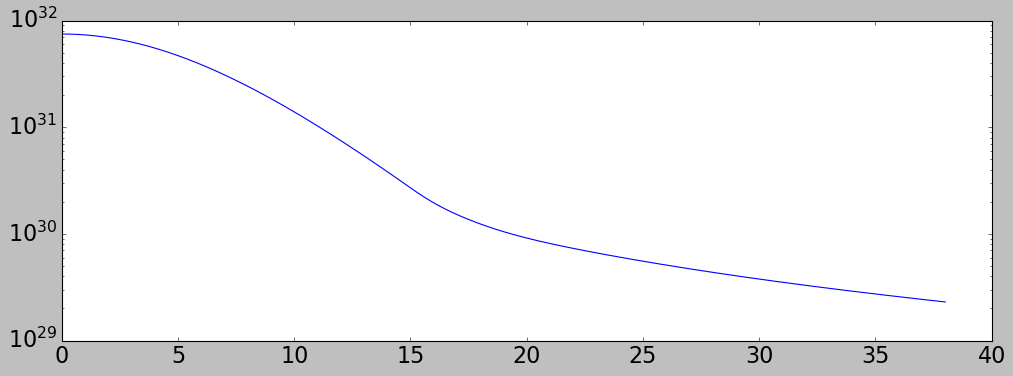

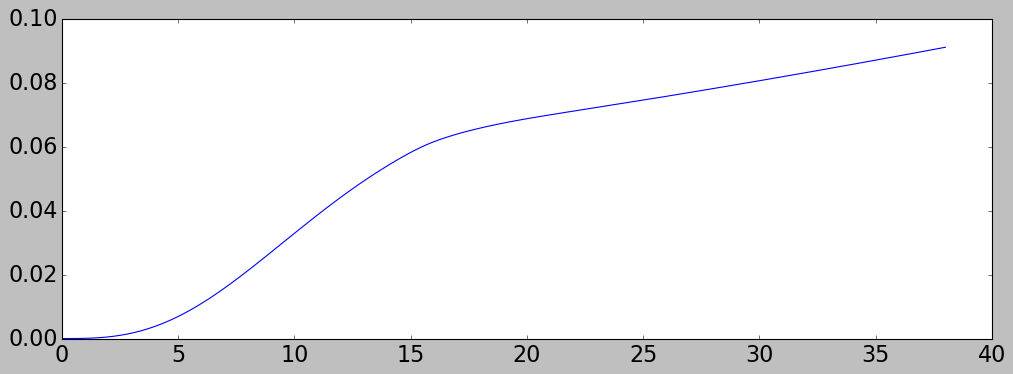

1
./eos_tables/ALF2_data.out


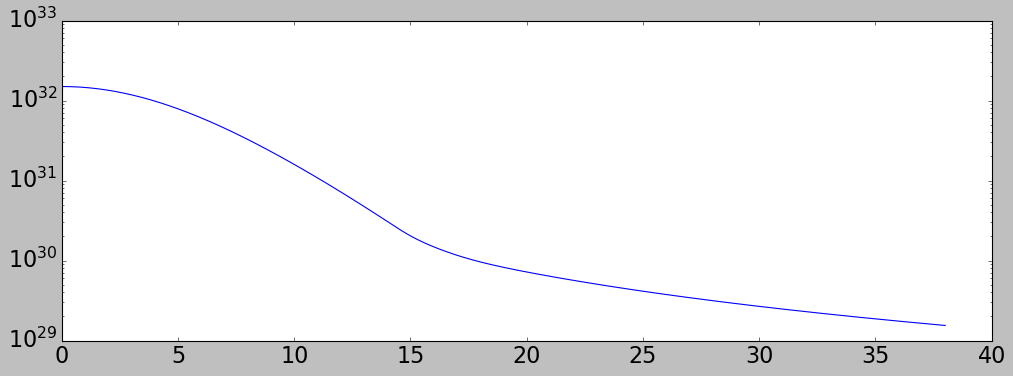

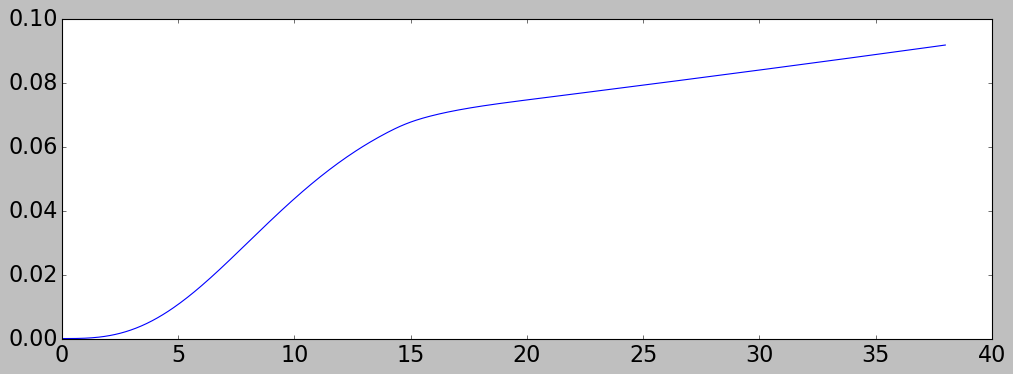

2
./eos_tables/ALF2_data.out


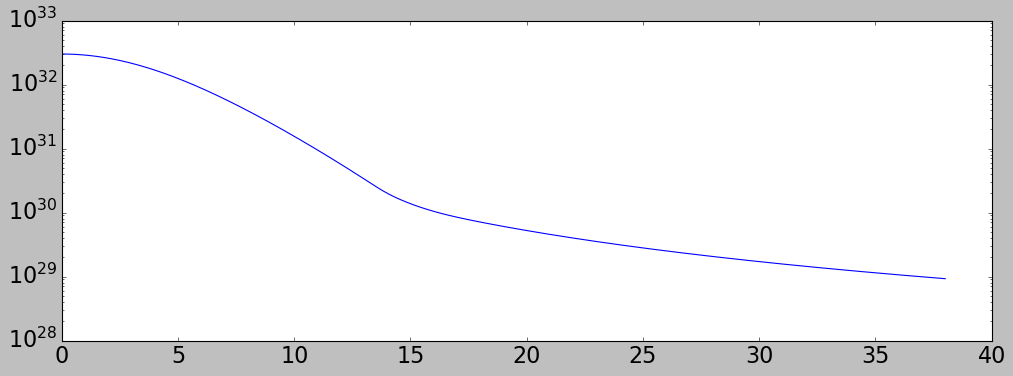

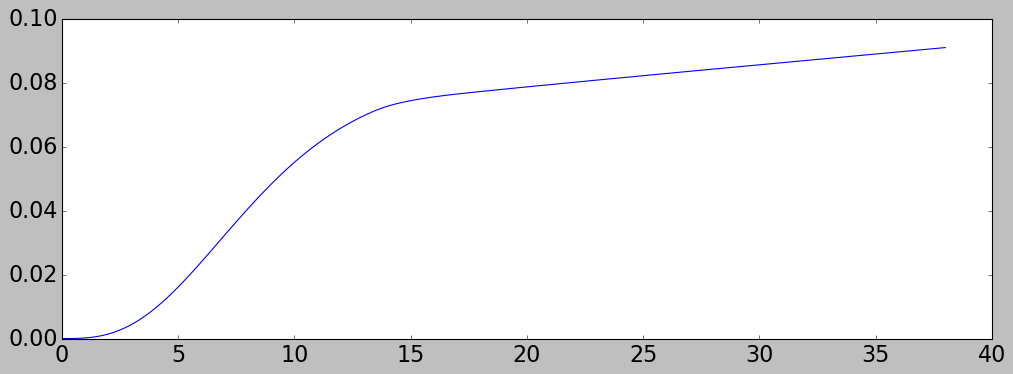

3
./eos_tables/ALF2_data.out


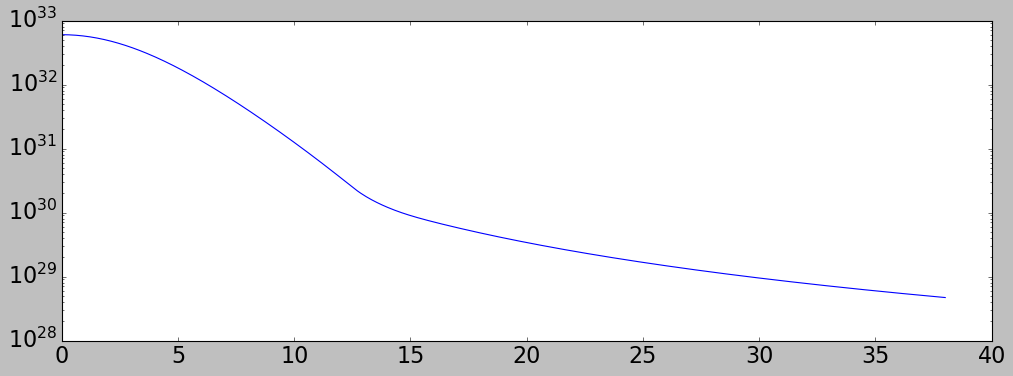

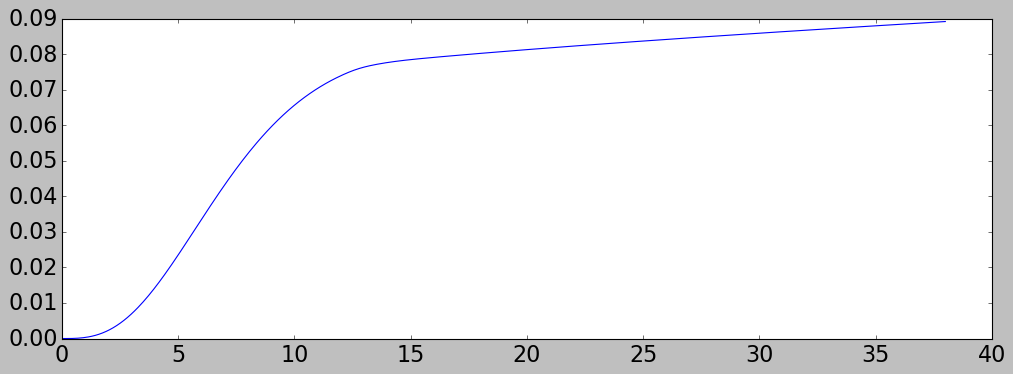

4
./eos_tables/ALF2_data.out


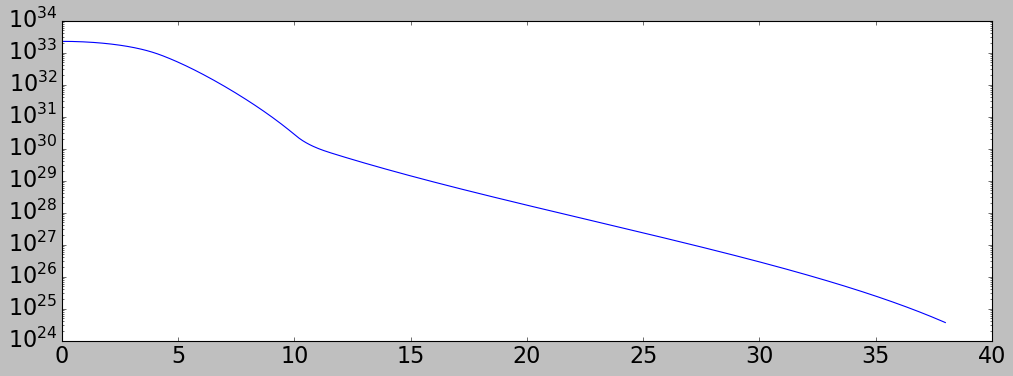

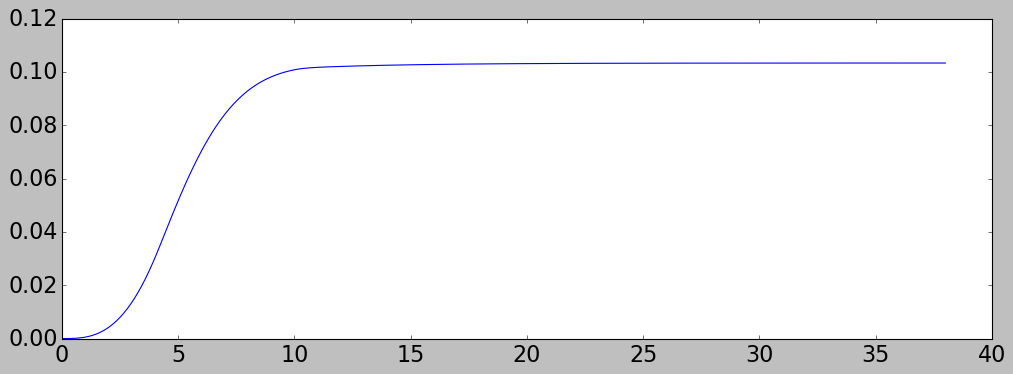

5
./eos_tables/ALF2_data.out


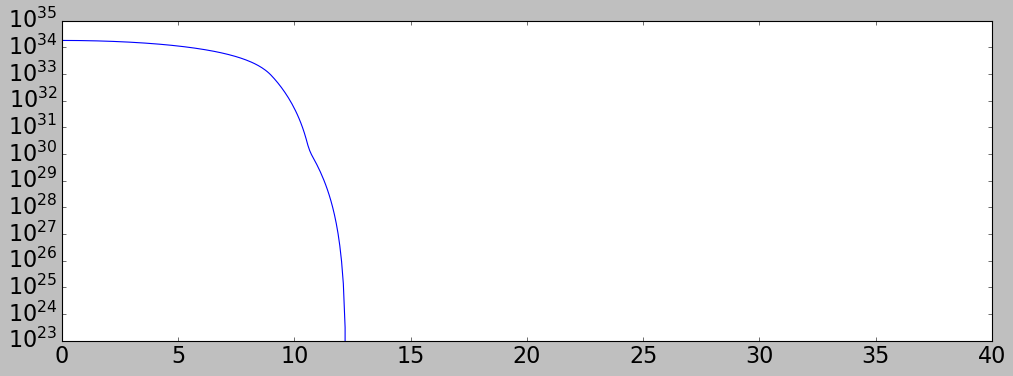

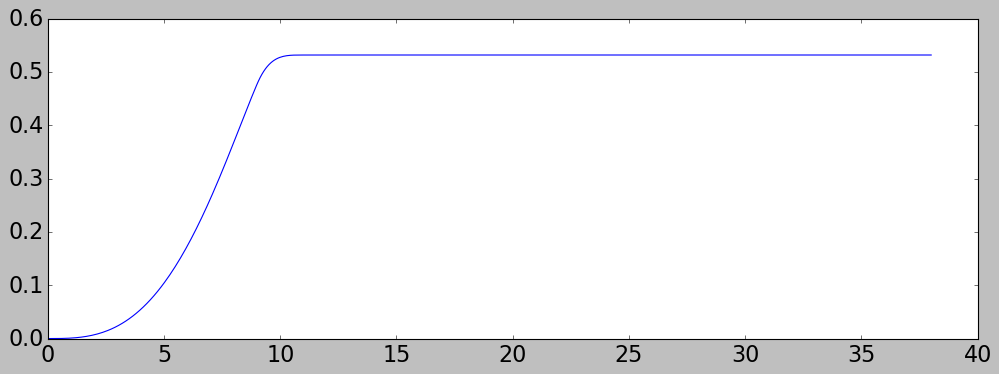

6
./eos_tables/ALF2_data.out


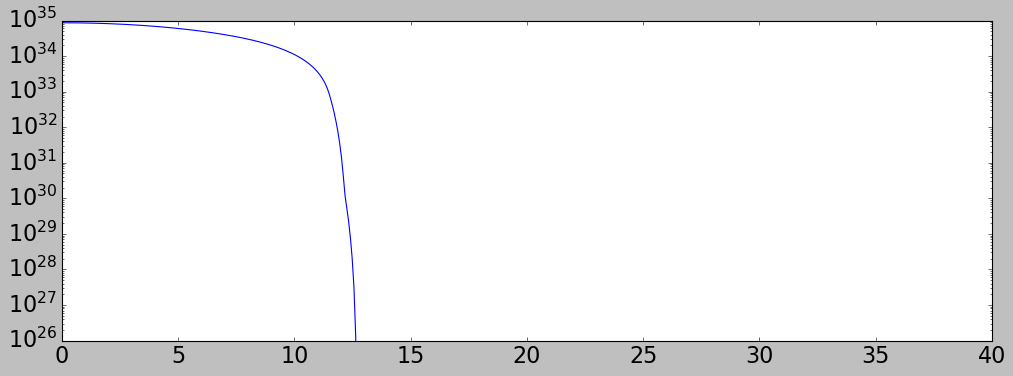

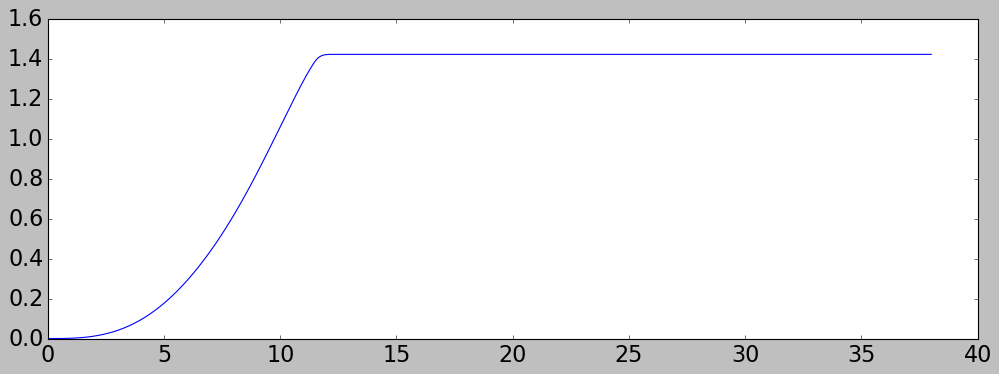

7
./eos_tables/ALF2_data.out


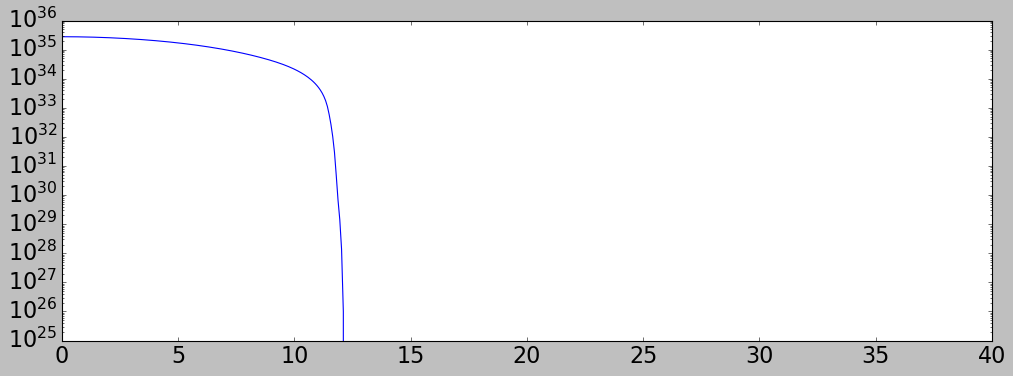

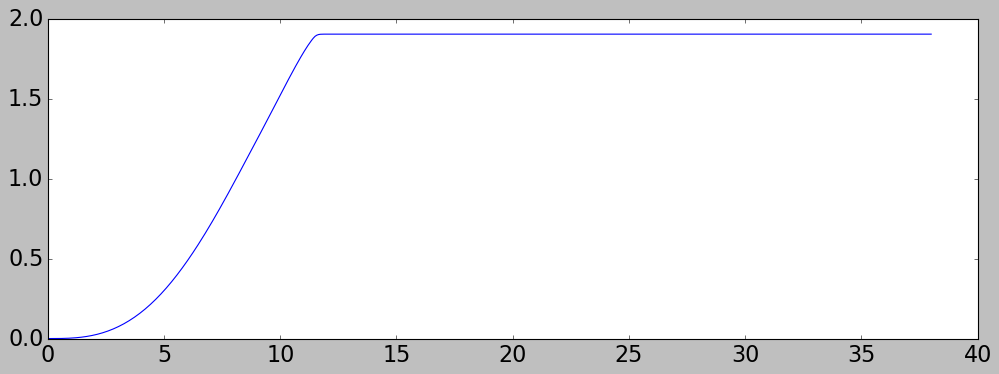

8
./eos_tables/ALF2_data.out


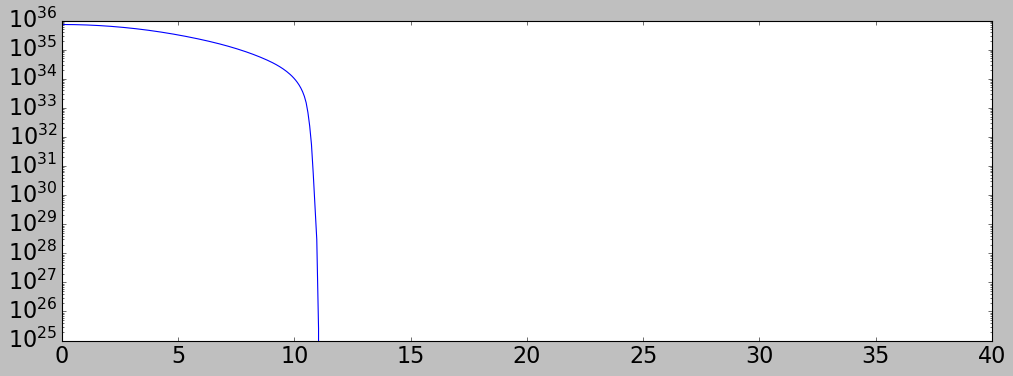

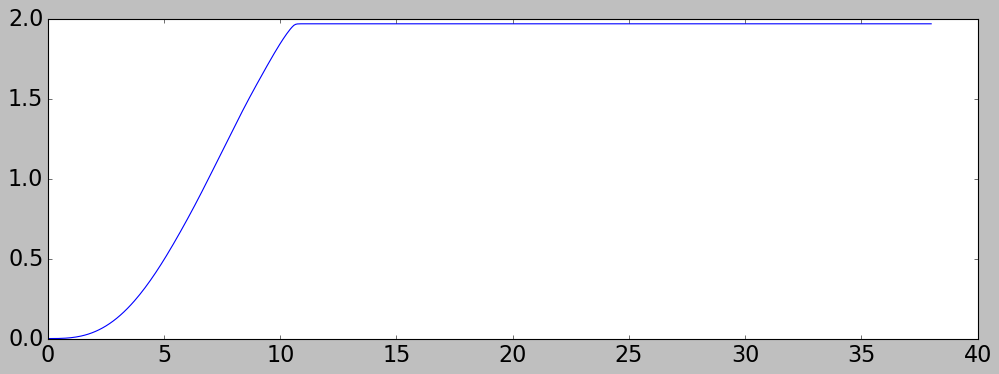

9
./eos_tables/ALF2_data.out


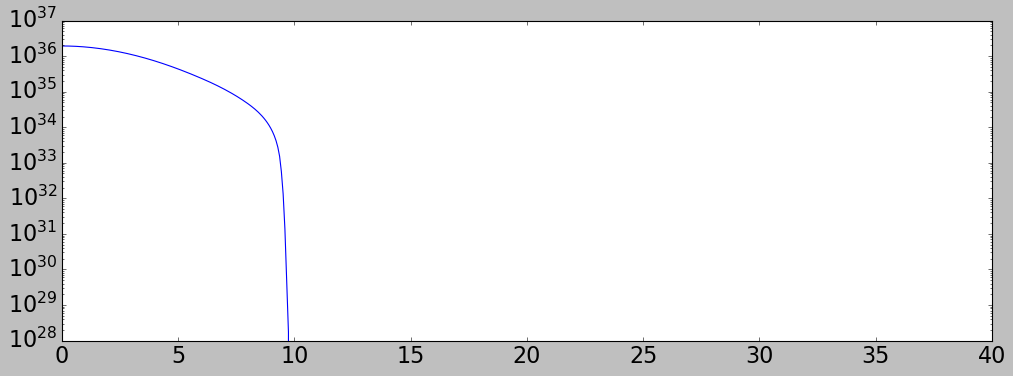

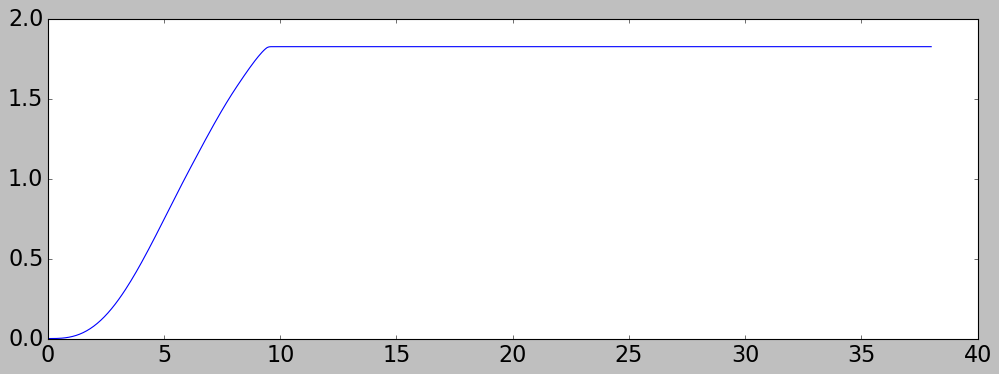

10


In [116]:
m_arr,r_arr,rhoc_arr,mb_arr,yp_arr=mass_radius()

In [65]:
#m_arr,r_arr,rhoc_arr,mb_arr,yp_arr=mass_radius()
ind=190
#print('m_arr = \n',m_arr[0:ind])
#print('r_arr = \n',len(r_arr[0:ind]),r_arr[0:ind])
#print('yp_arr = \n',yp_arr[0:ind])
#np.save('./eos_tables/BLH',[m_arr[0:ind],r_arr[0:ind],rhoc_arr[0:ind],mb_arr[0:ind],yp_arr[0:ind]])
#np.savetxt(f'./eos_tables/BLH_M_R_Mb_Lam.out',np.c_[m_arr[0:ind],r_arr[0:ind],rhoc_arr[0:ind],mb_arr[0:ind],yp_arr[0:ind]],header='#Mass Radius Baryonic_Mass Lambda \n',comments=f'#Mass(in solar mass), Radius(km), BaryonicMass(solar mass), Lambda(dimensional).\n')
blh_data=np.load('./eos_tables/BLH.npy',allow_pickle=True) 
print(len(blh_data[2]))

147


In [ ]:
blq=np.load('../EOS_data/BLQ')
np.savetxt(f'../EOS_Data/BLQ_M_R_Mb_Lam.out',np.c_[m_arr[0:ind],r_arr[0:ind],rhoc_arr[0:ind],mb_arr[0:ind],yp_arr[0:ind]],header='#Mass Radius Baryonic_Mass Lambda \n',comments=f'#Mass(in solar mass), Radius(km), BaryonicMass(solar mass), Lambda(dimensional).\n')


length of mass-radius points=200 in eos=BLQ
length of mass-radius points=291 in eos=ALF2
length of mass-radius points=147 in eos=BLH


ValueError: x and y must have same first dimension, but have shapes (100,) and (147,)

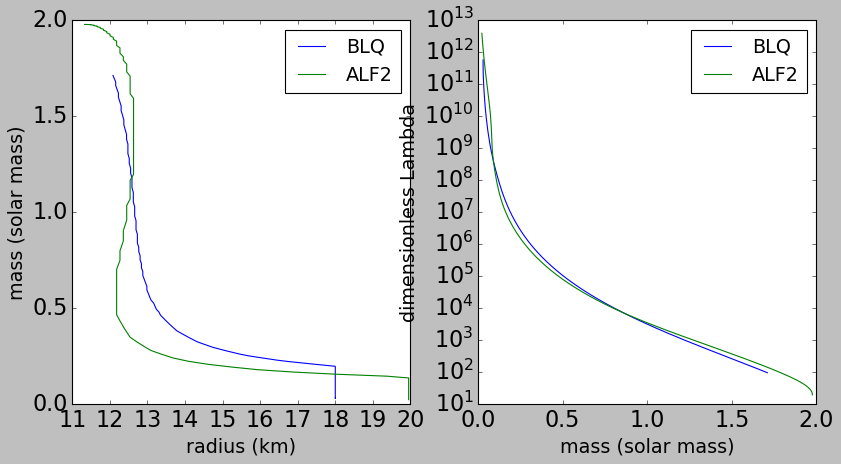

In [110]:
data_path='./m_mB_rad_data'
#data_path='../data/m_mB_rad_data'
#eos_list=['MS1','APR3','APR4','DD2','SLy','ALF2','BLQ']
eos_list=['BLQ','ALF2','BLH']

fig,((ax1,ax2))=plt.subplots(nrows=1,ncols=2,figsize=(12,6))
for eos in eos_list:
    ds=np.load(f'{data_path}/%s.npy'%eos,allow_pickle=True) #0:mass(msun), 1:radius(km), 2:rhoc(cgs), 4:lambda (in cgs)

    print(f'length of mass-radius points={len(ds[4])} in eos={eos}')
    #print(max(ds[0]))
    ax1.plot(ds[1],ds[0],label=eos)
    #ax1.plot(ds[1],ds[3],ls='--',label='mBaryonic')
    ax1.set(xlabel='radius (km)',ylabel='mass (solar mass)')
    ax1.legend()
    #plt.xlim([0.5,3.0])
    #plt.ylim([10,1.e6])
    #plt.clf()
    ax2.semilogy(ds[0],(ds[4]*const.CGS_G)*((const.CGS_C**2)/(const.CGS_G*ds[0]*const.CGS_MSUN))**5,label=eos)   #(lambda_out*const.CGS_G)*((const.CGS_C**2)/(const.CGS_G*mass_input*const.CGS_MSUN))**5
    ax2.legend()
    ax2.set(xlabel='mass (solar mass)',ylabel='dimensionless Lambda')
plt.xlabel('mass')
plt.ylabel(r'$\Lambda$')
#plt.savefig('blh_blq_mass-radius.png',dpi=150)
plt.show()

r
./matlab_Sebastiano/tov/Sequences/Complete/APR4_sequence.txt
length of mass-radius points=298 in eos=APR4
[18.         18.         18.         18.         18.         18.
 18.         18.         18.         18.         18.         18.
 18.         18.         18.         18.         18.         18.
 18.         18.         18.         18.         18.         18.
 18.         18.         18.         18.         18.         18.
 18.         18.         18.         18.         18.         18.
 18.         18.         18.         18.         18.         18.
 18.         18.         18.         18.         18.         18.
 18.         18.         18.         18.         18.         18.
 18.         18.         18.         18.         18.         18.
 18.         18.         18.         18.         18.         18.
 18.         18.         18.         18.         18.         18.
 18.         18.         18.         18.         18.         18.
 18.         18.         18.         18.       

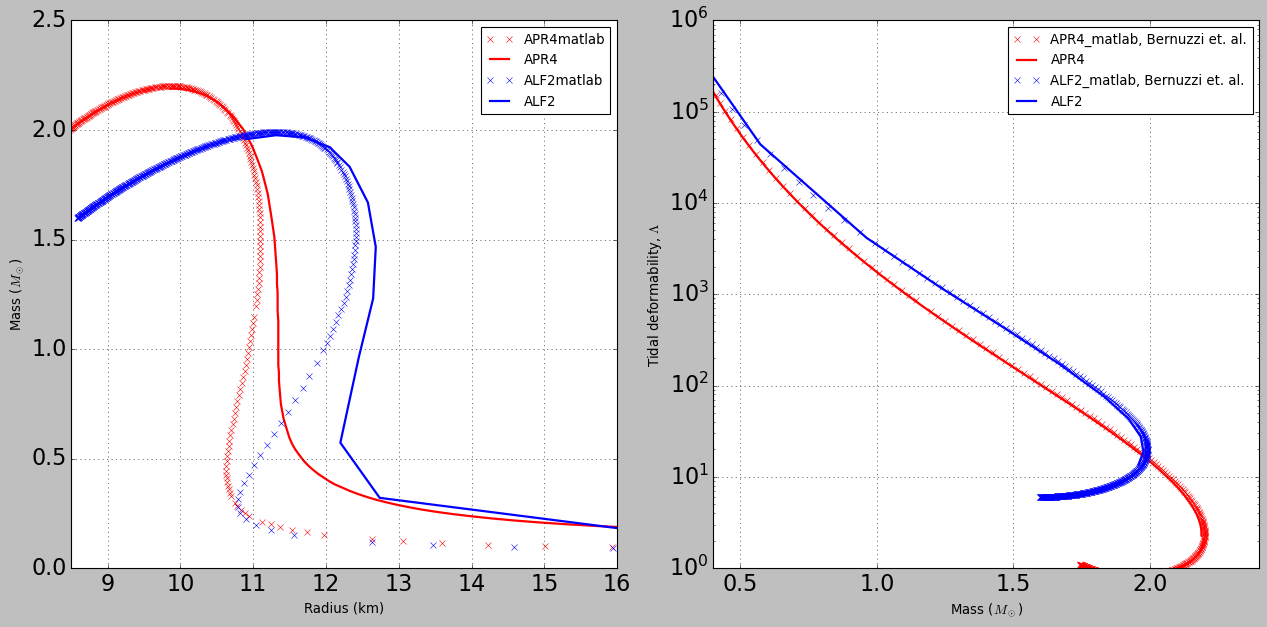

In [127]:
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
import numpy as np
    
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':20,
         'ytick.labelsize':20}
pylab.rcParams.update(params)


from cycler import cycler

#eos_data_path='../../../GRMHDResearch/_kilonovae_standardization/codes/src/tov/m_mB_rad_data'

eos_data_path='./m_mB_rad_data'
#data_path='../data/m_mB_rad_data'
#eos_list=['MS1','APR4','DD2','SLy','ALF2','H4'] #'APR3',
eos_list=['APR4','ALF2'] #,'APR3']

#['BLH','BLQ','H4','MPA1','MS1','SLy','WFF1','WFF2',]

#available Matlab sequences: 'MS1','APR4','DD2','SLy','ALF2',H4

sebastiano_data='./matlab_Sebastiano/tov/Sequences/Complete/'



#fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2,figsize=(24,16))
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(16,8))
legend_labelsize=12
xy_labelsize=12
custom_cycler = (cycler(color=['r', 'b', 'g', 'k','c','orange'])) #+ cycler(lw=[1, 2, 3, 4]))

#plt.rc('lines', linewidth=4)
#plt.rc('axes', prop_cycle=custom_cycler)

#fig.gca().set_color_cycle(['red', 'green', 'blue', 'yellow'])

#fig.suptitle('M-R relation')
for cc,eos in zip(custom_cycler,eos_list):
    print(cc['color'])
    file=sebastiano_data+eos+'_sequence.txt'  
    print(file)
    ds_matlab=np.loadtxt(file,skiprows=1)
    ax1.plot(ds_matlab[:,3]*const.AGEO_LENGTH_IN_M/1.e3,ds_matlab[:,1],'x',color=cc['color'],label=eos+'matlab')
    
    
    
    ds=np.load(f'{eos_data_path}/%s.npy'%eos) #0:mass(msun), 1:radius(km), 2:rhoc(cgs), 3: baryonic mass, 4:lambda (in cgs)
    print(f'length of mass-radius points={len(ds[4])} in eos={eos}')
    #print(max(ds[0]))
    print(ds[1])
    ax1.plot(ds[1],ds[0],color=cc['color'],lw=2,label=eos)
    #ax1.plot(ds[1],ds[3],color=cc['color'],ls='--',lw=2,label=eos+'M_Baryonic')
    
    
    m_new=np.linspace(0.5,1.9,100)
    C_arr,l_arr,r_arr=Compactness_MBaryon(m_new,eos)
    
    #ax1.plot(r_arr,m_new,'x',label='interpolated '+eos)
    ax1.set_xlabel(r'Radius (km)',fontsize=xy_labelsize)
    ax1.set_ylabel(r'Mass ($M_\odot$)',fontsize=xy_labelsize)
    ax1.set_xlim([8.5,16])
    ax1.legend(fontsize=legend_labelsize)
    ax1.grid(True)

    #ax3.plot(abs(ds[1]-r_arr)/ds[1],ds[0],'.',label=eos)
    #ax3.set(ylabel='mass',xlabel='relative interpolation error in radius')
    #ax3.set_xscale('log')
    #ax3.legend()
    
    ax2.semilogy(ds_matlab[:,1],ds_matlab[:,6],'x',color=cc['color'],label=eos+'_matlab, Bernuzzi et. al.')
    ax2.semilogy(ds[0],(ds[4]*const.CGS_G)*((const.CGS_C**2)/(const.CGS_G*ds[0]*const.CGS_MSUN))**5,color=cc['color'],lw=2,label=eos)   #(lambda_out*const.CGS_G)*((const.CGS_C**2)/(const.CGS_G*mass_input*const.CGS_MSUN))**5
    #ax2.semilogy(ds[0],ds[4],label=eos)
    #ax2.semilogy(m_new,l_arr,'x',label=f'interpolated {eos}')
    ax2.set_xlabel(r'Mass ($M_\odot$)',fontsize=xy_labelsize)
    ax2.set_ylabel(r'Tidal deformability, $\Lambda $',fontsize=xy_labelsize) #(g/cm^2/s^2)
    ax2.set_xlim([0.4,2.4])
    ax2.set_ylim([1,1.e6])
    ax2.legend(fontsize=legend_labelsize)
    ax2.grid(True)
            
    #ax3.plot(ds[0],ds[2],label=eos)
    
    #ax4.plot(ds[0],ds[3],label=eos)
ax1.set_prop_cycle(custom_cycler)
#plt.grid()
plt.tight_layout()
#plt.savefig('./data/m_mB_rad_data/plots/MR_eos.png',dpi=150)
plt.show()


['./matlab_Sebastiano/tov/Sequences/Complete/2B_sequence.txt', './matlab_Sebastiano/tov/Sequences/Complete/2H_sequence.txt', './matlab_Sebastiano/tov/Sequences/Complete/ALF2_sequence.txt', './matlab_Sebastiano/tov/Sequences/Complete/APR4_sequence.txt', './matlab_Sebastiano/tov/Sequences/Complete/BHBlp_sequence.txt', './matlab_Sebastiano/tov/Sequences/Complete/BLh_sequence.txt', './matlab_Sebastiano/tov/Sequences/Complete/DD2_sequence.txt', './matlab_Sebastiano/tov/Sequences/Complete/ENG_sequence.txt', './matlab_Sebastiano/tov/Sequences/Complete/H3_sequence.txt', './matlab_Sebastiano/tov/Sequences/Complete/H4_sequence.txt', './matlab_Sebastiano/tov/Sequences/Complete/HB_sequence.txt', './matlab_Sebastiano/tov/Sequences/Complete/LS200_sequence.txt', './matlab_Sebastiano/tov/Sequences/Complete/MPA1_sequence.txt', './matlab_Sebastiano/tov/Sequences/Complete/MS1b_sequence.txt', './matlab_Sebastiano/tov/Sequences/Complete/MS1_sequence.txt', './matlab_Sebastiano/tov/Sequences/Complete/SFHo_se

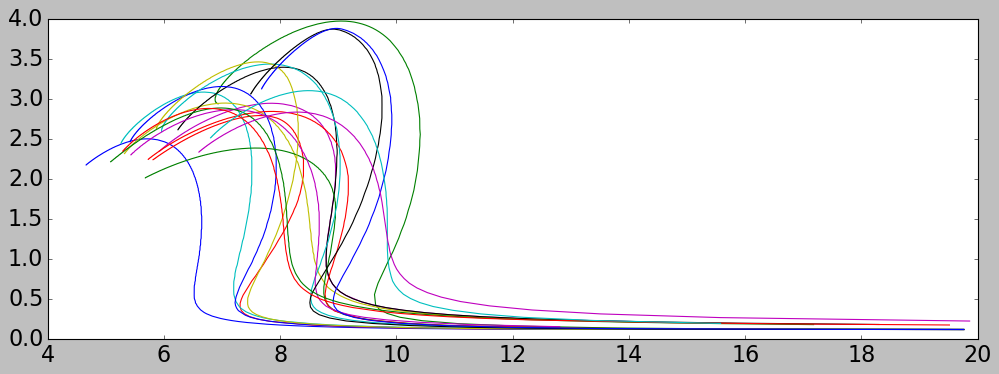

In [111]:
sebastiano_data='./matlab_Sebastiano/tov/Sequences/Complete/'
files=glob.glob(sebastiano_data+'/*txt')
print(files)

for f in files:
    eos=f.split(sebastiano_data)[1].split('.txt')[0].split('_sequence')[0]
    file=sebastiano_data+eos+'_sequence.txt'
    ds=np.loadtxt(file,skiprows=1)
    plt.plot(ds[:,3],1.4*ds[:,1],label=eos)
#plt.legend()
plt.show()

In [ ]:
from scipy.integrate import odeint

import myconstants as const
from numpy import diff
import numpy as np

c=const.CGS_C
G=const.CGS_G
Msun=const.CGS_MSUN

fm=1.e-13 #1femotometer in cm
dens_conversion=const.CGS_AMU/(fm**3)
edens_conversion=const.CGS_C**2

#eos_file='./tov/m_mB_rad_data/ALF2_data.out'

#eos_file='../EOS_Data/BLQ_gibbs_180_10-Mar-2020.lorene'
#eos_file='../EOS_Data/BLQ_data.out'



#eos_files='../EOS_Data/sfho+BL_01-Apr-2019.lorene'
eos_file='./eos_tables/BLH_data.out'

def calc_tidal_deformability(C, Y,m):
    """ Compute the dimensionless tidal deformability parameter Lambda from the compactness C and
    the Lindblom y-potential at the surface of a polytropic star"""
    # Eq.(C1,C2) of Lindblom & Indik 2014
    zeta = 4. * C**3 * (13. - 11.*Y + C*(3.*Y-2.) + 2.*(C**2)*(1.+Y)) + 3. * ((1.-2.*C)**2) * (2. - Y + 2.*C*(Y-1.)) *np.log(1.-2.*C) + 2. * C * (6. - 3.*Y + 3.*C*(5.*Y-8.))
    Lambda_dimensionless = (16./(15.*zeta)) * ((1.-2.*C)**2) * (2. + 2.*C*(Y-1.) - Y)  #dimensionless tidal deformability
    lambda_dimensional =   Lambda_dimensionless/G *(G*m*Msun/c**2)**5
    return lambda_dimensional

def tov(y, r):
    P, m, m_baryon, yp = y
    
    rho,eden,eos_gamma=eos_from_pres(P,eos_file)
    eden=eden/c**2.
    #eden = self.physical_eos.edens_inv( P )
    #rho = self.physical_eos.rho( P )
    #eos_gamma = self.physical_eos.gamma_inv(P)
    pi=np.pi
    dPdr = -G*(eden + P/c**2)*(m + 4.0*pi*r**3*P/c**2)
    dPdr = dPdr/(r*(r - 2.0*G*m/c**2))
    dmdr = 4.0*pi*r**2*eden
    dm_baryondr = 4.0*pi*r**2*rho*(1-2*G*m/(r*c**2))**(-0.5)
    #G=cgs.G; c=cgs.c

    # Eq.(C7) of Lindblom & Indik 2014
    rho=eden*c**2 #converting to cgs units
    dypdr= -yp**2/r -(r + (G/c**4)*4*np.pi*r**3*(P-rho)) * yp/(r*(r-2*G*m/c**2)) + (G**2/c**4)*(4*(m+4*np.pi*r**3*P/c**2)**2)/(r*(r-2*G*m/c**2)**2) + 6/(r-2*G*m/c**2) - 4*np.pi*(r**2)*(5*rho+9*P+(rho+P)**2/(P*eos_gamma))*G/(c**4 * (r-2*G*m/c**2))

    return [dPdr, dmdr, dm_baryondr,dypdr]

def tovsolve(rhoc):
    N = 500
    r = np.linspace(1e0, 38e5, N)
    #print(r)
    print(eos_file)
    P,dummy = eos_from_dens(rhoc/dens_conversion,eos_file)
    rho,eden,gamma = eos_from_pres(P,eos_file)
    #gamma=1.6
    eden=eden/c**2.
    #print(rho,eden,gamma)
    #P = self.physical_eos.pressure( rhoc )
    #eden = self.physical_eos.edens_inv( P )
    #rho = self.physical_eos.rho( P )
    pi=np.pi
    m = 4.0*pi*r[0]**3*eden
    m_baryon = 4.0*pi*r[0]**3*rho*(1-2*G*m/(r[0]*c**2))**(-0.5)
    yp=2.
    psol = odeint(tov, [P, m, m_baryon, yp], r, rtol=1.0e-4, atol=1.0e-4)
    #psol = solve_ivp(tov, )
    #print m, m_baryon, rhoc
    return r, psol[:,0], psol[:,1], psol[:,2], psol[:,3]

def mass_radius():
    N = 10
    mcurve = np.zeros(N)
    rcurve = np.zeros(N)
    mbcurve = np.zeros(N)
    ypcurve = np.zeros(N)
    rhocs = np.logspace(13.5, 15.5, N)
    print(rhocs)
    mass_max = 0.0
    j = 0
    for rhoc in rhocs:
        rad, press, mass, mass_baryon, yp_lambda = tovsolve(rhoc)
    
        rad  /= 1.0e5 #cm to km
        mass /= Msun
        mass_baryon /=Msun
        
        plt.semilogy(rad,press)
        plt.show()
        
        plt.plot(rad,mass)
        plt.show()
        #print(mass)
        
        #print self.peos
        #print rad
        #print "Central Density=%f, Gravitational Mass=%f, Baryonic Mass=%f, Radius=%f"%(rhoc,mass.max(),mass_baryon.max(),rad.max())

        mstar = mass[-1]
        rstar = rad[-1]
        ypstar = yp_lambda[-1]
        for i, p in enumerate(press):
            if p > 0.0:
                mstar = mass[i]
                rstar = rad[i]
                mbaryonStar = mass_baryon[i]
                ypstar = yp_lambda[i]
                
        mcurve[j] = mstar
        rcurve[j] = rstar
        mbcurve[j] = mbaryonStar

        C=(G/c**2)*(mstar*Msun)/(rstar*1.e5)
        ypcurve[j] = ypstar
        ypcurve[j] = calc_tidal_deformability(C,ypstar,mstar)



        j += 1
        print(j)
        """ if mass_max < mstar:
            mass_max = mstar
            print('break',mass_max,mstar)
        else:
            print('break',mass_max,mstar)
            break"""

    return mcurve[:j], rcurve[:j], rhocs[:j], mbcurve[:j], ypcurve[:j]